In [6]:
import os
import re
import cv2
import json
import sys
sys.path.append('../')
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches

## 检查GPT生成的数据

In [33]:
image_dir = "../../../PanoData/360indoor/images"
output_dir = "../../SpatialR360_DG/output/Indoor360"
data_list = os.listdir(output_dir)
cur_data = data_list[1]

In [34]:
with open(os.path.join(output_dir, cur_data), 'r') as f:
    data = json.load(f)
image_id = data["image_id"]
reasoning_data = data["reasoning"]
image_path = os.path.join(image_dir, image_id+'.jpg')

(1920, 960)


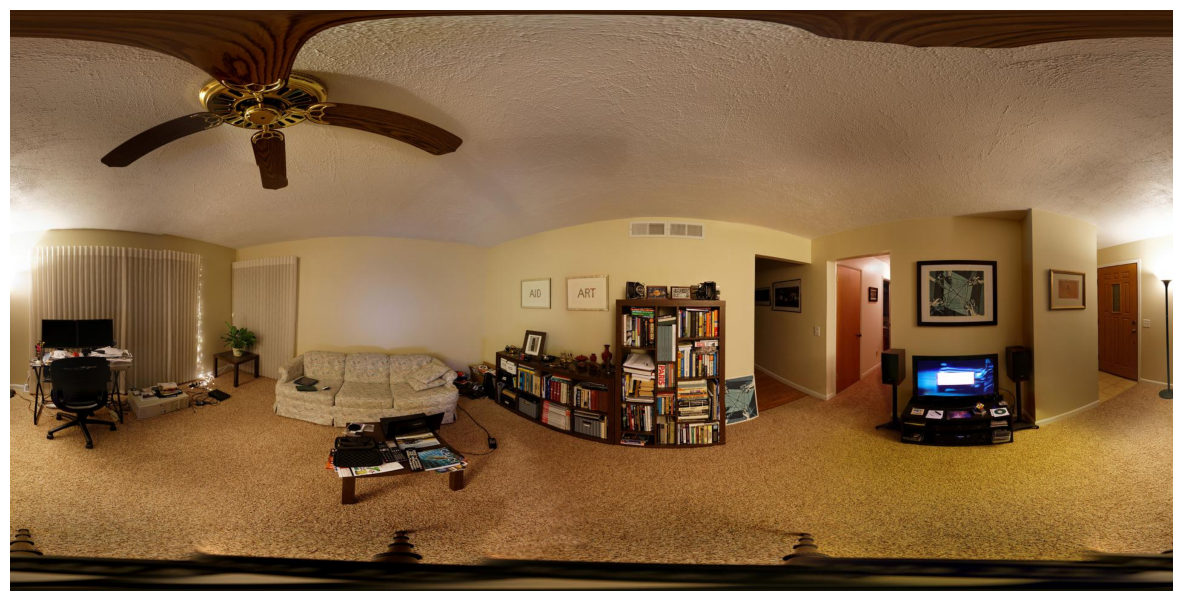

In [38]:
image = Image.open(image_path)
image.save('image.jpg')
print(image.size)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
axs.imshow(image)
axs.axis('off')
plt.show()

In [39]:
print(len(reasoning_data))
for re in reasoning_data:
    print("Question:\n{}".format(re["question"]))
    print("Chain:\n{}".format(re["reasoning_chain"]))
    print("Final:\n{}".format(re["final_answer"]))

5
Question:
What is the possible function of the region with the desk, computer monitor, and office chair located on the left side of the image?
Chain:
The presence of a desk, computer monitor, and office chair suggests that this area is set up for focused activities. These items are typically found in spaces dedicated to work, study, or computer use. The organization of cables and documents further supports the idea of a workspace. The placement near a window may provide natural light, which is desirable in a working environment.
Final:
Home office or study area.
Question:
How is the large bookshelf spatially related to the seating area in the room?
Chain:
The large bookshelf is placed directly to the right of the sofa, forming a continuous line along the wall. This proximity allows easy access to books or decorative items from the seating area. The arrangement suggests a reading or relaxation zone, with the bookshelf serving both storage and aesthetic functions.
Final:
The bookshelf 

## 检查数据集本身标注

In [105]:
# 模拟一张全景图（比如你可以替换成真实图像）
image_path = "../../../PanoData/360indoor/images/7fBM1.jpg"
image = np.array(Image.open(image_path))
annotation_dir = "../../../PanoData/360indoor/annotations"
annotation_path = os.path.join(annotation_dir, image_path.split('/')[-1].split('.')[-2]+'.json')
with open(annotation_path, 'r') as f:
    annotation = json.load(f)
boxes_list = annotation["boxes"]
box = boxes_list[10]
print(box)

[260, 635, -2.2923808894163025, -0.5056000676871072, 8, 8, 'chair']


### 检查中心点

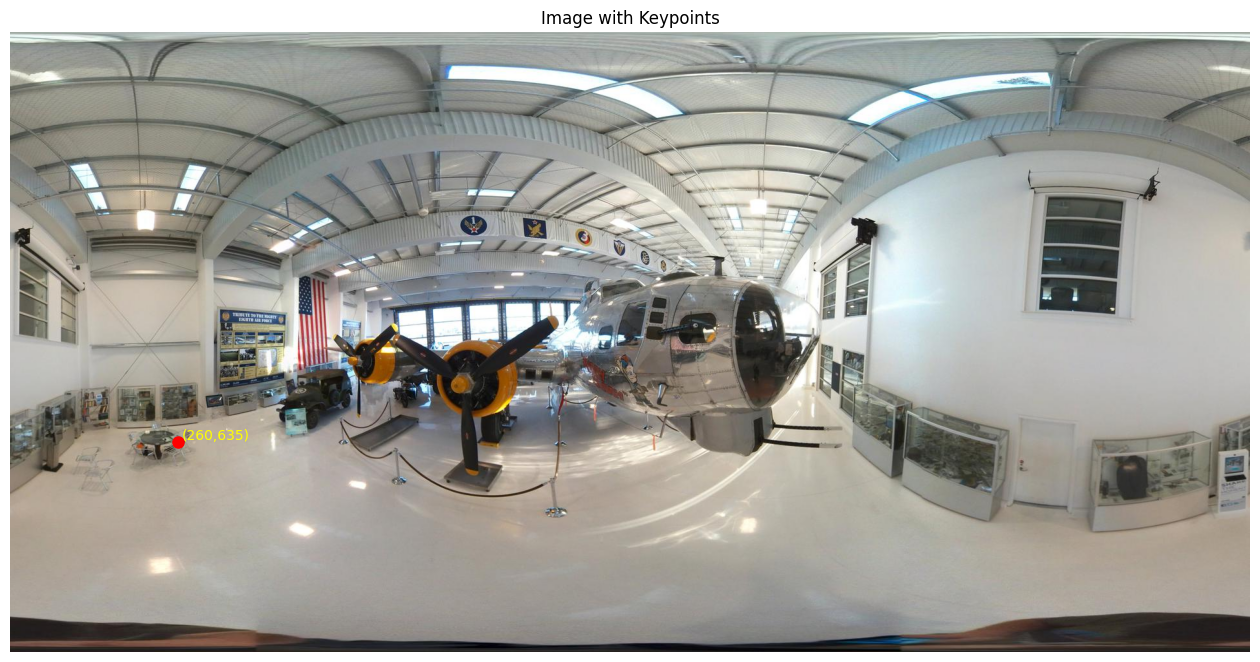

In [106]:
plt.figure(figsize=(16, 10))
plt.imshow(image)
plt.axis('off')

keypoints = [[box[0], box[1]]]
# 绘制关键点
for (x, y) in keypoints:
    plt.plot(x, y, 'ro', markersize=8)  # 红色圆点
    plt.text(x + 5, y - 5, f'({x},{y})', color='yellow', fontsize=10)  # 可选：添加文字标签

plt.title("Image with Keypoints")
plt.show()

### 检查Bfov标注

259.4999999999999 634.5
chair


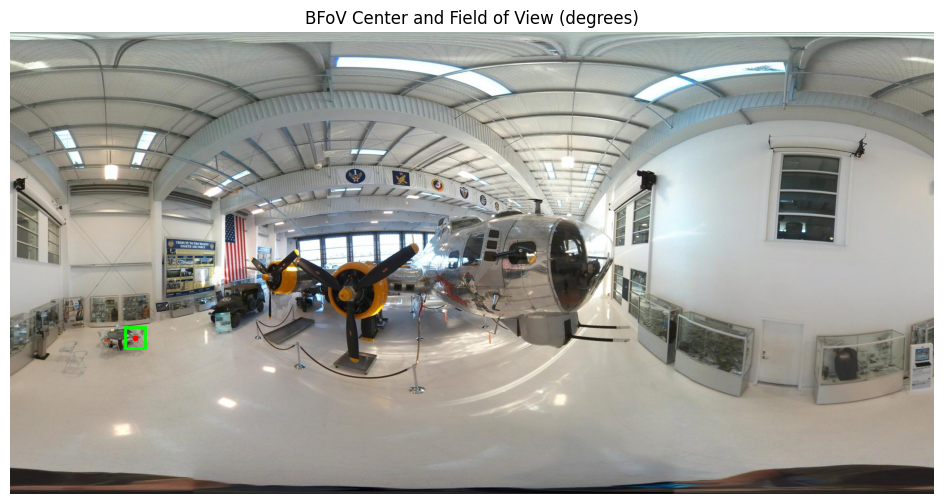

In [107]:
H, W = image.shape[:2]

# ---------- 2. BFoV 标注信息 ----------
phi, theta, w_deg, h_deg = box[2:6]

# ---------- 3. 转换函数：BFoV 中心点 (phi, theta) → 图像像素 (x, y) ----------
def bfof_center_to_pixel(phi, theta, W, H):
    """
    Convert (phi: longitude, theta: latitude) in radians
    to pixel coordinates (x, y) in equirectangular image.
    """
    x = (phi + np.pi) / (2 * np.pi) * W
    y = (np.pi / 2 - theta) / np.pi * H
    return x, y

# 中心点
cx, cy = bfof_center_to_pixel(phi, theta, W, H)
print(cx, cy)
print(box[-1])
# h_fov, v_fov
bbox_w = w_deg / 360 * W
bbox_h = h_deg / 180 * H
x1 = cx - bbox_w / 2
y1 = cy - bbox_h / 2

# ---------- 4. 可视化中心点 ----------
# ---------- 5. 可视化中心点和框 ----------
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(image)

# 中心点（青色）
ax.plot(cx, cy, 'o', color='red', markersize=3)

# FoV 框（绿色边框）
rect = plt.Rectangle((x1, y1), bbox_w, bbox_h, linewidth=2, edgecolor='lime', facecolor='none')
ax.add_patch(rect)

ax.set_title("BFoV Center and Field of View (degrees)")
plt.axis('off')
plt.show()

### 统计所有的类别名称

In [108]:
anno_dir = "../../../PanoData/360indoor/annotations"
anno_paths = os.listdir(anno_dir)
class_names = set()
for anno_name in anno_paths:
    anno_file = os.path.join(anno_dir, anno_name)
    with open(anno_file, 'r') as f:
        annotation = json.load(f)
    boxes_list = annotation["boxes"]
    for box in boxes_list:
        class_names.add(box[-1])
print(list(class_names))

['window', 'oven', 'bed', 'door', 'phone', 'backpack', 'bowl', 'keyboard', 'light', 'mirror', 'sink', 'book', 'fan', 'computer', 'heater', 'cabinet', 'refrigerator', 'airconditioner', 'mouse', 'bathtub', 'vase', 'cup', 'washer', 'chair', 'board', 'microwave', 'person', 'potted plant', 'fireplace', 'toilet', 'wine glass', 'clock', 'tv', 'sofa', 'picture', 'bottle', 'table']
